In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import add_dummy_feature
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
si = SimpleImputer()
import warnings
warnings.filterwarnings ('ignore')


In [10]:
df = pd.read_csv('/content/Deeplearning_Project.csv')

In [11]:
df.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.73,0,Caucasian,M,180.3,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0.0
1,114252,59342,81,77.0,27.42,0,Caucasian,F,160.0,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0.0
2,119783,50777,118,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0.0
3,79267,46918,118,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0.0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0.0


In [12]:
df.shape

(9206, 85)

In [64]:
df = df.mask(df == '')   # This will mask all missing values

In [14]:
df.drop(['encounter_id', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'patient_id', 'hospital_id','Unnamed: 83'], axis=1,inplace = True)

#Let's Visualize The data

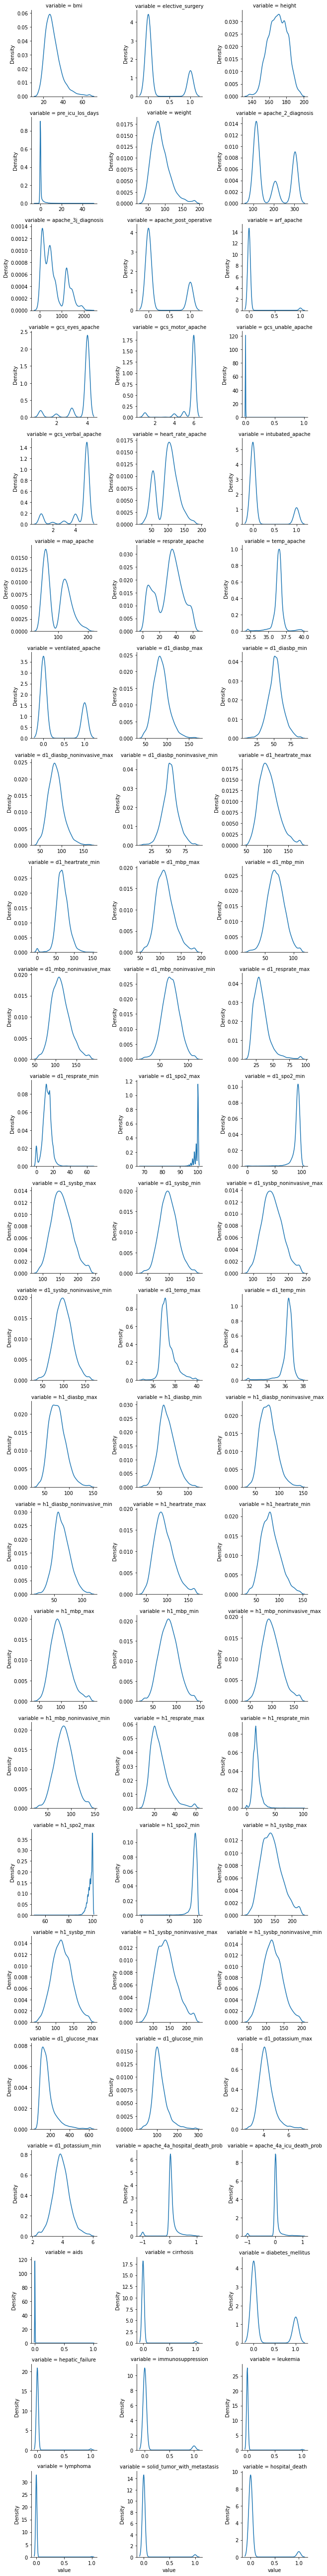

In [15]:
unpivot = pd.melt(df, df.describe().columns[0], df.describe().columns[1:])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, "value")

plt.show()

**The death rate for Male-Female patients is shown below. While the rate of female deaths are higher the youngest person to pass away during one of the case was a Male of 16yrs of age**

In [19]:
fig = px.histogram(df[['age','gender','hospital_death','bmi']].dropna(), x="age", y="hospital_death", color="gender",
                   marginal="box", # or violin, rug, box
                   hover_data=df[['age','gender','hospital_death','bmi']].columns)
fig.show()

In [20]:
ICU_type=df[['icu_type','age','hospital_death']]
ICU_type['icu_type']=ICU_type['icu_type'].replace({'CTICU':'CCU-CTICU',
                                              'Cardiac ICU':'CCT-CTICU',
                                              'CTICU':'CCT-CTICU',
                                              'CSICU':'SICU'})
#ICU_type['pre_icu_los_days']=ICU_type['pre_icu_los_days'].round(0)
ICU_df=ICU_type.groupby(['icu_type','age']).mean().reset_index()
ICU_df['count']=ICU_type.groupby(['icu_type','age']).count().reset_index()['hospital_death']

In [21]:
ICU_type.value_counts() # Lets see which types of ICU are present

icu_type      age   hospital_death
Med-Surg ICU  68.0  0.0               116
              67.0  0.0               115
              64.0  0.0               113
              76.0  0.0               109
              60.0  0.0               107
                                     ... 
              24.0  1.0                 1
              26.0  1.0                 1
              28.0  1.0                 1
              29.0  1.0                 1
SICU          89.0  1.0                 1
Length: 630, dtype: int64

In [22]:
df['hospital_death'].value_counts() # Total Deaths among all ICU types = 1

0.0    8635
1.0     570
Name: hospital_death, dtype: int64

Lets Plot a chart to see death ratio in detail

In [23]:
fig = px.scatter(ICU_df, x="age", y="hospital_death", size="count", color="icu_type",
           hover_name="icu_type", log_x=False, size_max=60,)
fig.update_layout(
    title_text="Death rate at different types of ICU"
)
fig.update_yaxes(title_text="Average Hospital Death")
fig.update_xaxes(title_text="Age")
fig.show()

Above chart shows that Mid-Surgical ICU have maximum death count. Now let's get bar plot for same.

In [24]:
fig = px.bar(ICU_df, x="age", y="hospital_death", color="icu_type",
           hover_name="icu_type", log_x=False,)
fig.update_layout(
    title_text="Death rate at different types of ICU"
)
fig.update_yaxes(title_text="Average Hospital Death")
fig.update_xaxes(title_text="Age")
fig.show()

# Let's Start Data Cleaning

In [25]:
df_num = [                             # This is to seperate numerical variables from categorical variables
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

df_cat = ['ethnicity',
 'gender',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

In [26]:
df.nunique()[df.nunique() == 2].index.tolist() # This will show the unique values of each column but don't convert it. 

['elective_surgery',
 'gender',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'hospital_death']

In [27]:
df.select_dtypes(include='O').columns.values.tolist()

['ethnicity',
 'gender',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

In [28]:
not_numeric = df[df_num + df_cat + ['hospital_death']].columns.tolist() # This will return only Numeric column
numeric_only = df.drop(not_numeric,axis=1).columns.tolist()
numeric_only

['age',
 'bmi',
 'height',
 'pre_icu_los_days',
 'weight',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_verbal_apache',
 'heart_rate_apache',
 'map_apache',
 'resprate_apache',
 'temp_apache',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_diasbp_noninvasive_max',
 'h1_diasbp_noninvasive_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_mbp_noninvasive_max',
 'h1_mbp_noninvasive_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_spo2_max',
 'h1_spo2_min',
 'h1_sysbp_max',
 'h1_sysbp_min',
 'h1_sysbp_n

In [29]:
for col in df_num:                      # Let's put for loop to fill all null values in Categorical column of dataset with MODE
    df[col] = df[col].astype('Int64')
    
for col in df_cat:
    df[col] = df[col].fillna(df[col].mode()[0]) 

In [30]:
df.head()

,age,bmi,elective_surgery,ethnicity,gender,height,icu_type,pre_icu_los_days,weight,apache_2_diagnosis,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,hospital_death
0,68.0,22.73,0,Caucasian,M,180.3,CTICU,0.541667,73.9,113.0,...,0,1,0,0,0,0,0,Sepsis,Cardiovascular,0.0
1,77.0,27.42,0,Caucasian,F,160.0,Med-Surg ICU,0.927778,70.2,108.0,...,0,1,0,0,0,0,0,Respiratory,Respiratory,0.0
2,25.0,31.95,0,Caucasian,F,172.7,Med-Surg ICU,0.000694,95.3,122.0,...,0,0,0,0,0,0,0,Metabolic,Metabolic,0.0
3,81.0,22.64,1,Caucasian,F,165.1,CTICU,0.000694,61.7,203.0,...,0,0,0,0,0,0,0,Cardiovascular,Cardiovascular,0.0
4,19.0,NaN,0,Caucasian,M,188.0,Med-Surg ICU,0.073611,NaN,119.0,...,0,0,0,0,0,0,0,Trauma,Trauma,0.0


In [31]:
df[numeric_only].isna().sum(axis=0).sort_values(ascending=False) # Let's sort Null values of Numerical column as well

h1_mbp_noninvasive_min           1756
h1_mbp_noninvasive_max           1756
bmi                              1707
weight                           1659
d1_potassium_min                  868
d1_potassium_max                  868
h1_diasbp_noninvasive_min         857
h1_diasbp_noninvasive_max         857
h1_sysbp_noninvasive_min          856
h1_sysbp_noninvasive_max          856
h1_mbp_min                        575
h1_mbp_max                        575
h1_resprate_min                   557
h1_resprate_max                   557
d1_glucose_min                    525
d1_glucose_max                    525
apache_4a_icu_death_prob          493
apache_4a_hospital_death_prob     493
d1_mbp_noninvasive_max            467
d1_mbp_noninvasive_min            467
age                               431
apache_2_diagnosis                230
h1_diasbp_max                     210
h1_sysbp_max                      210
h1_sysbp_min                      210
h1_diasbp_min                     210
h1_spo2_min 

In [32]:
split_one = df[numeric_only].isna().sum(axis=0).sort_values()[df[numeric_only].isna().sum(axis=0) < 1800].index.tolist()
split_two = df[numeric_only].isna().sum(axis=0).sort_values()[df[numeric_only].isna().sum(axis=0) > 1800].index.tolist()

In [33]:
for col in split_two:
    df[col] = df[col].fillna(df[col].mean())

process_data = df.dropna(axis=0)

In [34]:
process_data[df_cat].nunique()

ethnicity                6
gender                   2
icu_type                 6
apache_3j_bodysystem    11
apache_2_bodysystem     10
dtype: int64

**Using get_dummies to convert categorical data into indicator variables**

In [35]:
icu_data = pd.get_dummies(process_data,
    prefix='isin',
    prefix_sep='_',
    columns=df_cat,
    drop_first=False)
icu_data.reset_index(drop = True, inplace = True)
icu_data

,age,bmi,elective_surgery,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,...,isin_Cardiovascular,isin_Gastrointestinal,isin_Haematologic,isin_Metabolic,isin_Neurologic,isin_Renal/Genitourinary,isin_Respiratory,isin_Trauma,isin_Undefined Diagnoses,isin_Undefined diagnoses
0,68.0,22.730000,0,180.30,0.541667,73.9,113.0,502.01,0,0,...,1,0,0,0,0,0,0,0,0,0
1,77.0,27.420000,0,160.00,0.927778,70.2,108.0,203.01,0,0,...,0,0,0,0,0,0,1,0,0,0
2,67.0,27.560000,0,190.50,0.000694,100.0,301.0,403.01,0,0,...,0,0,0,0,1,0,0,0,0,0
3,50.0,25.710000,0,175.30,0.060417,79.0,112.0,107.01,0,0,...,1,0,0,0,0,0,0,0,0,0
4,72.0,28.257052,1,154.90,0.004861,67.8,303.0,1304.08,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4683,56.0,25.927736,0,187.96,0.000000,91.6,122.0,703.02,0,0,...,0,0,0,1,0,0,0,0,0,0
4684,71.0,31.313194,0,167.64,0.048611,88.0,302.0,109.09,0,0,...,1,0,0,0,0,0,0,0,0,0
4685,50.0,31.040564,0,157.50,0.002778,77.0,113.0,502.01,0,0,...,1,0,0,0,0,0,0,0,0,0
4686,61.0,41.374283,0,172.70,0.001389,123.4,117.0,106.01,0,0,...,1,0,0,0,0,0,0,0,0,0


In [36]:
icu_data.columns = [x.lower() for x in icu_data.columns.tolist()] # Get duplicate values
icu_data = icu_data.loc[:,~icu_data.columns.duplicated()] 

In [37]:
t = icu_data['arf_apache'].dtype       # Here i use tqdm to see Progress Bar because of time consumption in data processing
for col in tqdm(icu_data.columns.tolist()):
    if icu_data[col].values.dtype == 'uint8' or t == icu_data[col].values.dtype:
        icu_data[col] = icu_data[col].astype(int)

100%|██████████| 102/102 [00:00<00:00, 2856.18it/s]


In [38]:
icu_data.dtypes          # Let's check datatypes in Numerical Columns

age                         float64
bmi                         float64
elective_surgery              int64
height                      float64
pre_icu_los_days            float64
                             ...   
isin_trauma                   int64
isin_haematologic             int64
isin_neurologic               int64
isin_renal/genitourinary      int64
isin_undefined diagnoses      int64
Length: 102, dtype: object

**Let's Split The data into Train and Test set for Model building**

In [39]:
x = icu_data.drop(['hospital_death'], axis=1)      # Have to add in between columns also in 'x' 
y = icu_data['hospital_death'] 
x1 = x[['apache_4a_hospital_death_prob','apache_4a_icu_death_prob','age','d1_spo2_min','d1_resprate_max','d1_heartrate_min']]
xtrain,xtest,ytrain,ytest = train_test_split(x1,y,test_size=0.30,random_state=1)

In [40]:
print(xtrain.shape)
print(ytrain.shape)

(3281, 6)
(3281,)


In [41]:
from numpy import asarray
from sklearn.preprocessing import StandardScaler

In [42]:
sc = StandardScaler()

In [43]:
xtrain = sc.fit_transform(xtrain)
xtest = sc.transform(xtest)

In [44]:
ann = Sequential()

In [45]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

In [47]:
ann.add(Dense(units=30,activation='relu'))
ann.add(Dense(units=15,activation='relu'))
ann.add(Dense(units=1,activation='sigmoid'))
ann.compile(optimizer='adam',loss="binary_crossentropy")

In [48]:
earlystop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=25)

In [49]:
ann.fit(xtrain,ytrain,epochs=600,validation_data=(xtest,ytest),callbacks=[earlystop])

Epoch 1/600
103/103 [==============================] - 1s 3ms/step - loss: 0.4434 - val_loss: 0.2753
Epoch 2/600
103/103 [==============================] - 0s 2ms/step - loss: 0.2392 - val_loss: 0.2060
Epoch 3/600
103/103 [==============================] - 0s 2ms/step - loss: 0.2056 - val_loss: 0.1891
Epoch 4/600
103/103 [==============================] - 0s 2ms/step - loss: 0.1962 - val_loss: 0.1821
Epoch 5/600
103/103 [==============================] - 0s 2ms/step - loss: 0.1905 - val_loss: 0.1782
Epoch 6/600
103/103 [==============================] - 0s 2ms/step - loss: 0.1865 - val_loss: 0.1759
Epoch 7/600
103/103 [==============================] - 0s 2ms/step - loss: 0.1813 - val_loss: 0.1731
Epoch 8/600
103/103 [==============================] - 0s 2ms/step - loss: 0.1783 - val_loss: 0.1704
Epoch 9/600
103/103 [==============================] - 0s 2ms/step - loss: 0.1742 - val_loss: 0.1698
Epoch 10/600
103/103 [==============================] - 0s 2ms/step - loss: 0.1708 - val_lo

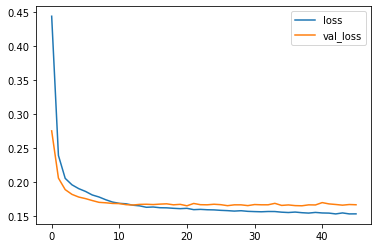

In [50]:
lossdf=pd.DataFrame(ann.history.history)
lossdf.plot()

In [58]:
def mymodel(model):             # this is function to check each and every algorithm on model
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)
    
    train = model.score(xtrain,ytrain)
    test = model.score(xtest,ytest)
    
    print(f"training accuracy is {train}\nTesting accuracy is:{test}")
    print (classification_report(ytest,ypred))
    

In [60]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, classification_report

In [61]:
sv = mymodel(SVC())

training accuracy is 0.9491008838768669
Testing accuracy is:0.9381663113006397
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      1321
         1.0       0.47      0.10      0.17        86

    accuracy                           0.94      1407
   macro avg       0.71      0.55      0.57      1407
weighted avg       0.92      0.94      0.92      1407



In [62]:
lg = mymodel(LogisticRegression())

training accuracy is 0.9454434623590369
Testing accuracy is:0.9353233830845771
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      1321
         1.0       0.40      0.12      0.18        86

    accuracy                           0.94      1407
   macro avg       0.67      0.55      0.57      1407
weighted avg       0.91      0.94      0.92      1407



In [63]:
xg = mymodel(XGBClassifier())

training accuracy is 0.9579396525449558
Testing accuracy is:0.9424307036247335
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      1321
         1.0       0.56      0.26      0.35        86

    accuracy                           0.94      1407
   macro avg       0.76      0.62      0.66      1407
weighted avg       0.93      0.94      0.93      1407

